# V-10 flight simulation
This notebook is being developed by the avionics and flight dynamics sub-teams in The Rocket Launchers student organization at the University of Texas Rio Grande Valley. Our rocket's name is V-10 in celebration of our club's 10th anniversary! V-10 will be competing in the 10k COTS division at IREC. 

Key features of V-10:
- Air brakes
- vonKarman Nose Cone
- Replaceable fins


In [1]:
from rocketpy import Environment, SolidMotor, Rocket, Flight, TrapezoidalFins, EllipticalFins, RailButtons, NoseCone, Tail, Parachute
import datetime 


## Environment


In [ ]:
env = Environment()
env.set_location(latitude=28.61, longitude=-80.6)
env.set_elevation(1402.0800000000002)


Optionally, you can set the date and atmospheric model


In [ ]:
tomorrow = datetime.date.today() + datetime.timedelta(days=1)
env.set_date((tomorrow.year, tomorrow.month, tomorrow.day, 12))
env.set_atmospheric_model(type='Forecast', file='GFS')

In [ ]:
env.all_info()


## Motor
V-10 uses an AeroTech M2500T (98 mm) solid motor. We load the thrust curve from the local ENG file and set geometry and masses as follows:

- Diameter: 98 mm (outer grain radius 0.049 m)
- Grain length used: 0.732 m
- Propellant mass: 4.711 kg
- Total motor mass: 8.064 kg → Dry mass used: 3.353 kg
- Average thrust: ~2,500 N; Max thrust: ~3,711–4,081 N; Total impulse: ~9,671 Ns
- Nozzle radius: 0.03675 m; Throat radius: 0.0245 m
- Orientation: combustion_chamber_to_nozzle

These values are reflected directly in the code below.


In [2]:
m2500t = SolidMotor(
    thrust_source='../../data/AeroTech_M2500T.eng',
    dry_mass=3.353,  # Total 8.064 kg - Propellant 4.711 kg per cell 8
    center_of_dry_mass_position=0,
    dry_inertia=[0, 0, 0],
    grains_center_of_mass_position=0,
    grain_number=1,
    # Set density to match 4.711 kg propellant mass given geometry
    grain_density=1137.5,
    grain_outer_radius=0.049,  # 98 mm diameter
    grain_initial_inner_radius=0.0245,
    grain_initial_height=0.732,  # Length per cell 8
    grain_separation=0,
    nozzle_radius=0.036750000000000005,
    nozzle_position=0.351,  # Sign flipped for new orientation
    throat_radius=0.0245,
    reshape_thrust_curve=False,  # Not implemented in Rocket-Serializer
    interpolation_method='linear',
    coordinate_system_orientation='combustion_chamber_to_nozzle',  # Aligned with rocket direction
)

In [ ]:
m2500t.all_info()


## Rocket
V-10 is a single-stage rocket. We first define aerodynamic surfaces, then assemble the rocket with mass/inertia and drag models.

- Reference radius: 0.0777875 m
- Dry mass (without motor): 17.732 kg
- Center of mass (without motor): 1.41 m from nose tip
- Inertia tensor (about body axes): [0.115, 0.115, 21.424] kg·m²
- Coordinate system orientation: nose_to_tail

Next, we create surfaces (nose cone, fins, boat tail) and then build the rocket object with the above properties.


### Nose cone
V-10 uses a Haack (Von Kármán equivalent) nose cone with:
- Length: 0.381 m
- Base radius: 0.0777875 m

We'll use RocketPy's Von Karman nose cone with these dimensions.

In [3]:
nosecone = NoseCone(
    length=0.381,
    kind='Von Karman',
    base_radius=0.0777875,
    rocket_radius=0.0777875,
    name='Nose Cone',
)


In [ ]:
nosecone.draw()

### Fins
Using dimensions from the V-10 design, we approximate the freeform fin set as trapezoidal fins:

- Count: 4 fins
- Root chord: 0.3048 m
- Tip chord: 0.01905 m (based on planform points)
- Span: 0.1524 m
- Leading-edge sweep length: 0.254 m

These values match the fin planform used for V-10.

In [4]:
fins = TrapezoidalFins(
    n=4,
    root_chord=0.3048,
    tip_chord=0.01905,
    span=0.1524,
    sweep_length=0.254,
    rocket_radius=0.0777875,
    name="CF Trapezoidal (approx from V-10)",
)

In [ ]:
fins.draw()

### Transitions (Tails)
Boat tail per V-10:
- Shape: Conical
- Length: 0.0508 m
- Fore (top) radius: 0.0777875 m (matches body)
- Aft (bottom) radius: 0.0635 m

We'll create this as a Tail surface and add it to the rocket at the aft end.

In [5]:
tails = {}


In [6]:
tails[0] = Tail(
    top_radius=0.0777875,
    bottom_radius=0.0635,
    length=0.0508,
    rocket_radius=0.0777875,
    name='Boat Tail',
)


### Parachutes
Using the V-10 model data and converting diameter to CdS (CdS = CD × area):
- Main: CD = 2.2, Diameter = 2.7432 m → area ≈ 5.909 m² → CdS ≈ 13.0 (we use 13.003)
- Drogue: CD = 2.2, Diameter = 0.6096 m → area ≈ 0.2918 m² → CdS ≈ 0.642

We trigger the main by altitude (396.24 m) and the drogue at apogee.

In [ ]:
parachutes = {}


In [ ]:
parachutes[0] = Parachute(
    name='Main Parachute + Bag',
    cd_s=13.003,
    trigger=396.240,
    sampling_rate=100, 
)


In [ ]:
parachutes[1] = Parachute(
    name='Drogue',
    cd_s=0.642,  # Corrected: CD * area = 2.2 * 0.292
    trigger='apogee',
    sampling_rate=100, 
)


In [7]:
import numpy as np

# Initial Cd vs Mach curves for V-10; tune later with flight data or CFD.
cd_power_off = np.array([
    [0.00, 0.45],
    [0.50, 0.50],
    [0.90, 0.55],
    [1.00, 0.75],
    [1.20, 0.65],
    [2.00, 0.50],
    [3.00, 0.45],
])

cd_power_on = np.array([
    [0.00, 0.40],
    [0.50, 0.45],
    [0.90, 0.50],
    [1.00, 0.70],
    [1.20, 0.60],
    [2.00, 0.45],
    [3.00, 0.40],
])

rocket = Rocket(
    radius=0.0777875,
    mass=17.732,  # Matched to OpenRocket (without motor)
    inertia=[0.115, 0.115, 21.424],
    power_off_drag=cd_power_off,
    power_on_drag=cd_power_on,
    center_of_mass_without_motor=1.41,  # Matched via calculation from OpenRocket
    coordinate_system_orientation='nose_to_tail',
)


### Adding surfaces to the rocket
We add:
- Nose cone at 0.0 m (tip reference)
- Fins at 2.592 m (root leading edge per V-10 geometry)
- Boat tail at 2.8964 m (aft end)

Positions are measured from the nose tip following the 'nose_to_tail' convention.


In [8]:
rocket.add_surfaces(surfaces=[nosecone, fins, tails[0]], positions=[0.0, 2.592, 2.8964])

In [9]:
rocket.add_motor(m2500t, position=2.562)


Adding parachutes to the rocket


In [ ]:
rocket.parachutes = list(parachutes.values())


### Rail Buttons
Positions derived from V-10's launch lugs (converted to distances from the nose tip and centered on lug length 0.0381 m):
- Upper button center ≈ 1.7778 m
- Lower button center ≈ 1.3906 m
- Angular position: 60°

In [ ]:
rail_buttons = rocket.set_rail_buttons(
   upper_button_position=1.7778,
   lower_button_position=1.3906,
   angular_position=60.0,
)


Inertia Details

Rocket Mass: 17.732 kg (without motor)
Rocket Dry Mass: 21.085 kg (with unloaded motor)
Rocket Loaded Mass: 25.795 kg
Rocket Structural Mass Ratio: 0.817
Rocket Inertia (with unloaded motor) 11: 3.857 kg*m2
Rocket Inertia (with unloaded motor) 22: 3.857 kg*m2
Rocket Inertia (with unloaded motor) 33: 21.424 kg*m2
Rocket Inertia (with unloaded motor) 12: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 13: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 23: 0.000 kg*m2

Geometrical Parameters

Rocket Maximum Radius: 0.0777875 m
Rocket Frontal Area: 0.019009 m2

Rocket Distances
Rocket Center of Dry Mass - Center of Mass without Motor: 0.183 m
Rocket Center of Dry Mass - Nozzle Exit: 1.320 m
Rocket Center of Dry Mass - Center of Propellant Mass: 0.969 m
Rocket Center of Mass - Rocket Loaded Center of Mass: 0.177 m


Aerodynamics Lift Coefficient Derivatives

Nose Cone Lift Coefficient Derivative: 2.000/rad
CF Trapezoidal (approx from V-10) Lift Coefficient Derivative: 8

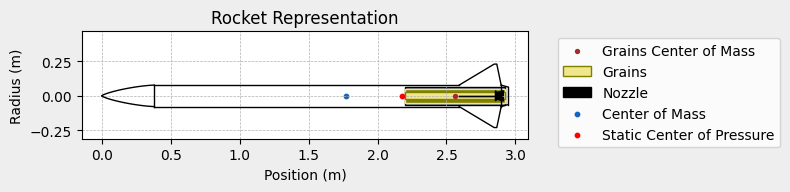


Mass Plots
----------------------------------------


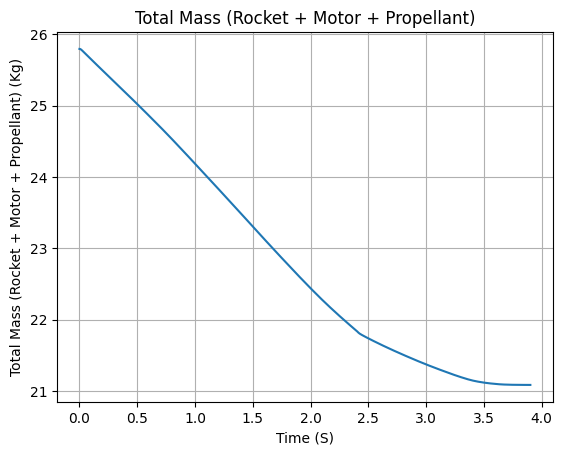

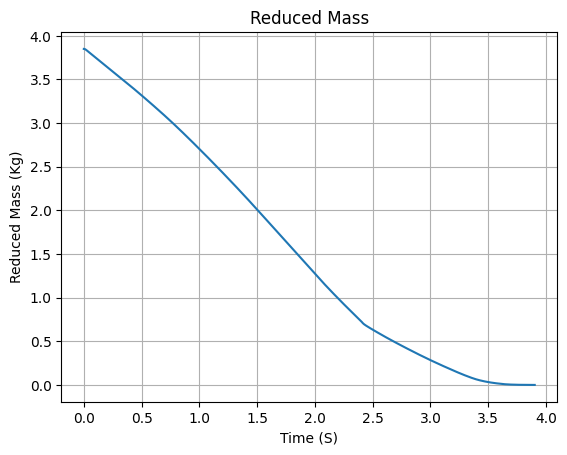


Aerodynamics Plots
----------------------------------------
Drag Plots
--------------------


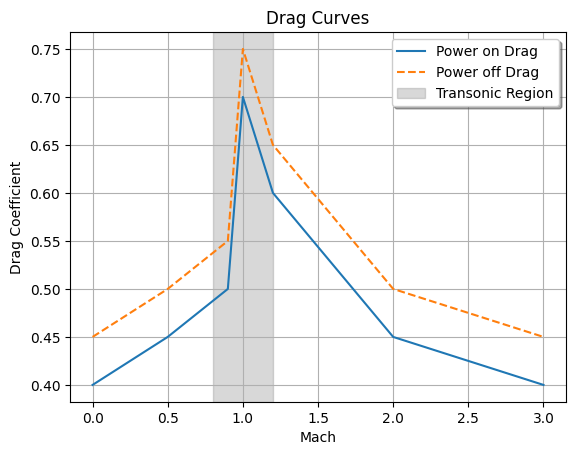


Stability Plots
--------------------


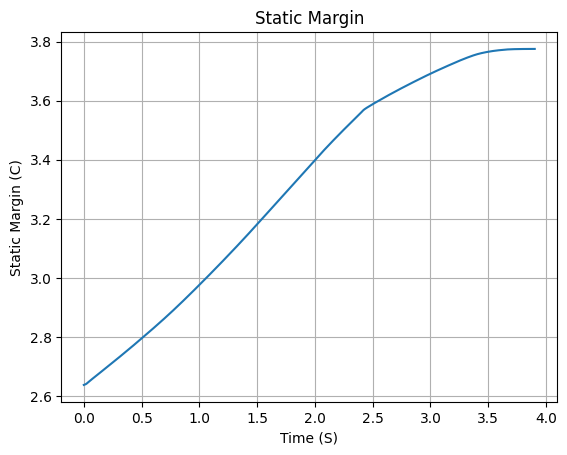

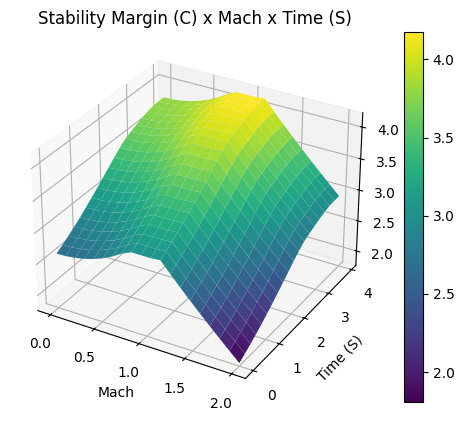


Thrust-to-Weight Plot
----------------------------------------


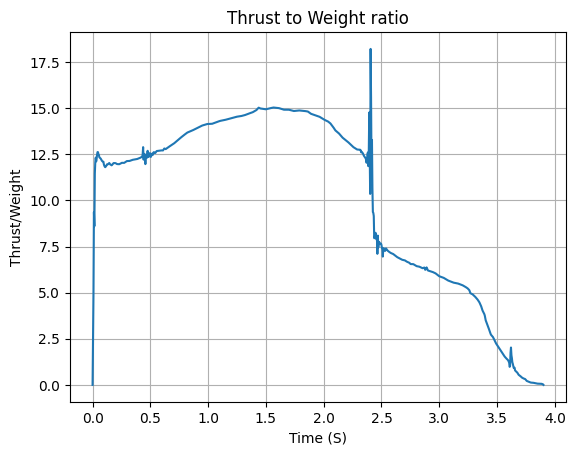

In [10]:
### Rocket Info
rocket.all_info()


## Flight
We will now create the flight simulation. Let's go!


In [ ]:
flight = Flight(
    rocket=rocket,
    environment=env,
    rail_length=5.1816,
    inclination=90.0,
    heading=90.0,
    terminate_on_apogee=False,
    max_time=600,
)

In [ ]:
flight.all_info()
